<h1>Capstone 1: Exploratory Data Analysis (EDA)</h1>

<a id='TOC'></a>
<strong>Table of Contents</strong>
<ol>
    <li>Preliminaries</li>
    <ol>
        <li><a href=#Sec01A>Import EMS Incident Data</a></li>
        <li><a href=#Sec01B>Import Shapefile</a></li>
        <li><a href=#Sec01C>Incident Outcomes</a></li>
    </ol>
    <li>Fatalities by Time Period</li>
    <ol>
        <li><a href=#Sec02A>Fatality Time Series</a></li>
        <li><a href=#Sec02B>Fatality Time Series by Year</a></li>
        <li><a href=#Sec02C>Fatalities by Month</a></li>
        <li><a href=#Sec02D>Fatalities by Time of Year</a></li>
        <li><a href=#Sec02E>Fatalities by Time of Week</a></li>
    </ol>
    <li>Incident Response Times</li>
    <ol>
        <li><a href=#Sec03A>Total Response Times</a></li>
        <li><a href=#Sec03B>Response Times by Incident Outcome</a></li>
        <li><a href=#Sec03C>Response Time by Final Severity Level</a></li>
    </ol>
    <li>Incident Call Types &amp; Severity Levels</li>
    <ol>
        <li><a href=#Sec04A>Fatalities by Call Type</a></li>
        <li><a href=#Sec04B>Incident Outcomes by Severity Level</a></li>
    </ol>
    <li>Fatalities by Geographic Region</li>
    <ol>
        <li><a href=#Sec05A>Fatalities by Borough</a></li>
        <li><a href=#Sec05B>Fatalities by ZIP Code</a></li>
    </ol>
</ol>

<p>The goal of this project is to develop machine learning models that predict whether or not the outcome of an EMS incident will result in a fatality. This is a supervised, binary classification problem. Analyses will be performed on a collection of nearly 8 million records of documented incidents, which span the six year period from January 2013 through December 2018, and appropriate predictive models will be developed to achieve the primary objective. This dataset is robust and contains several feature variables, of mixed data types, that describe both various attributes of each incident as well as the responsive action taken by the FDNY. All of the aforementioned factors affect an individual’s survivability once a response is initiated.</p>

<p>Exploratory data analysis was conducted prior to the development of any ML algorithms. The purpose of this process was to reveal trends that can help identify key feature variables and also provide contextual insights about the dataset.</p>

<hr>

<h2 style="text-transform: uppercase;">1. Preliminaries</h2>

<a id='Sec01A'></a>
<h4>1A: Import EMS Incident Data</h4>

In [1]:
# Import packages and modules
import pandas as pd
import numpy as np

import datetime
import math
import calendar
import matplotlib.dates as mdates
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
from pylab import *
import shapefile as shp
%matplotlib inline

sb.set(style='whitegrid', palette='pastel', color_codes=True)
sb.mpl.rc('figure', figsize=(15,10))

In [2]:
# Assign file path
input_path_ems = '../data/clean_EMS_data.csv'

# Read CSV data into a Pandas DataFrame
datetime_cols = ['incident_datetime',
                 'first_assignment_datetime',
                 'first_activation_datetime',
                 'first_on_scene_datetime',
                 'first_to_hosp_datetime',
                 'first_hosp_arrival_datetime',
                 'incident_close_datetime']

df = pd.read_csv(input_path_ems,compression='gzip',
                 parse_dates=datetime_cols,
                 index_col=['incident_datetime'])

In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8054500 entries, 2018-12-31 23:59:46 to 2013-01-09 09:05:12
Data columns (total 29 columns):
year                           int64
month                          int64
day                            int64
hour                           int64
weekday                        int64
borough                        object
zipcode                        float64
latitude                       float64
longitude                      float64
aland_sqmi                     float64
awater_sqmi                    float64
initial_call_type              object
initial_severity_level         int64
final_call_type                object
final_severity_level           int64
held_indicator                 object
first_assignment_datetime      datetime64[ns]
incident_dispatch_area         object
dispatch_time                  int64
first_activation_datetime      datetime64[ns]
first_on_scene_datetime        datetime64[ns]
travel_time                    int6

In [4]:
# Change dtypes
df['borough'] = df.borough.astype('category')
df['zipcode'] = df.zipcode.astype('category')
df['held_indicator'] = df.held_indicator.astype('category')
df['incident_dispatch_area'] = df.incident_dispatch_area.astype('category')
df['incident_disposition_code'] = df.incident_disposition_code.astype('category')

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8054500 entries, 2018-12-31 23:59:46 to 2013-01-09 09:05:12
Data columns (total 29 columns):
year                           int64
month                          int64
day                            int64
hour                           int64
weekday                        int64
borough                        category
zipcode                        category
latitude                       float64
longitude                      float64
aland_sqmi                     float64
awater_sqmi                    float64
initial_call_type              object
initial_severity_level         int64
final_call_type                object
final_severity_level           int64
held_indicator                 category
first_assignment_datetime      datetime64[ns]
incident_dispatch_area         category
dispatch_time                  int64
first_activation_datetime      datetime64[ns]
first_on_scene_datetime        datetime64[ns]
travel_time                 

In [6]:
df.head()

,year,month,day,hour,weekday,borough,zipcode,latitude,longitude,aland_sqmi,...,first_activation_datetime,first_on_scene_datetime,travel_time,response_time,first_to_hosp_datetime,first_hosp_arrival_datetime,incident_close_datetime,incident_disposition_code,life_threatening,fatality
incident_datetime,,,,,,,,,,,,,,,,,,,,,
2018-12-31 23:59:46,2018,12,31,23,1,BROOKLYN,11201.0,40.6937,-73.989859,1.407,...,2019-01-01 00:00:51,2019-01-01 00:07:27,453,461,2019-01-01 00:15:08,2019-01-01 00:21:51,2019-01-01 01:00:20,82,True,False
2018-12-31 23:49:42,2018,12,31,23,1,BROOKLYN,11201.0,40.6937,-73.989859,1.407,...,2018-12-31 23:50:27,2018-12-31 23:55:10,303,328,2019-01-01 00:15:40,2019-01-01 00:28:05,2019-01-01 01:11:13,82,True,False
2018-12-31 23:24:58,2018,12,31,23,1,BROOKLYN,11201.0,40.6937,-73.989859,1.407,...,2018-12-31 23:25:37,2018-12-31 23:32:03,414,425,2019-01-01 00:03:55,2019-01-01 00:12:16,2019-01-01 00:45:31,82,False,False
2018-12-31 23:04:54,2018,12,31,23,1,BROOKLYN,11201.0,40.6937,-73.989859,1.407,...,2018-12-31 23:05:17,2018-12-31 23:16:13,668,679,NaT,NaT,2018-12-31 23:48:12,93,False,False
2018-12-31 22:08:50,2018,12,31,22,1,BROOKLYN,11201.0,40.6937,-73.989859,1.407,...,2018-12-31 22:09:35,2018-12-31 22:16:25,443,455,2018-12-31 22:27:08,2018-12-31 22:39:30,2018-12-31 23:05:01,82,True,False


[TOC](#TOC)

<a id='Sec01B'></a>
<h4>1B: Import Shapefile for NYC</h4>

In [7]:
# Read shapefile data into object
input_path_shp = '../data/ZIP_CODE_040114/ZIP_CODE_040114.shp'
sf = shp.Reader(input_path_shp)

In [8]:
# Define function to read shapefile object into Pandas DataFrame
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the 
    pyshp package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    dfObj = pd.DataFrame(columns=fields, data=records)
    dfObj = dfObj.assign(coords=shps)
    return dfObj

In [9]:
# Read shapefile into DataFrame
map_df = read_shapefile(sf)
map_df.columns = [str(col).lower() for col in map_df.columns]
map_df.head()

,zipcode,bldgzip,po_name,population,area,state,county,st_fips,cty_fips,url,shape_area,shape_len,coords
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"[(1038098.2518714815, 188138.38000671566), (10..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"[(1001613.7129640579, 186926.4395172149), (100..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"[(1011174.275535807, 183696.33770971), (101137..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"[(995908.3654508889, 183617.61280155182), (996..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"[(991997.1134308875, 176307.4958601296), (9920..."


<p>This shapefile is provided by the Department of Information Technology &amp; Telecommunications (DoITT) of the City of New York, and was last updated on September 10, 2018. <a href=#TOC>TOC</a></p>

<em>Source: <a href="https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u" target="_blank">NYC OpenData, ZIP Code Boundaries</a></em>

<a id='Sec01C'></a>
<h4>1C: Incident Outcomes</h4>

<p>A natural starting point to investigate this dataset was to answer the following question: How many total recorded incidents resulted in a fatality?</p>

In [10]:
# Total Number of Fatalities Resulting from EMS Incidents (2013-2018)
df.fatality.value_counts()

False    7715190
True      339310
Name: fatality, dtype: int64

In [11]:
# Subset all incidents based on outcome
fatalities = df[df.fatality==True]
survivals = df[df.fatality==False]

In [12]:
# Total Percentage of Fatalities Resulting from EMS Incidents (2013-2018)
df.fatality.value_counts(normalize=True)

False    0.957873
True     0.042127
Name: fatality, dtype: float64

<p>Of the 7,988,028 observations used in this analysis, only 338,684 (~4.24%) resulted in a fatality. <a href=#TOC>TOC</a></p>

<hr>

<h2 style="text-transform: uppercase;">2. Fatalities by Time Period</h2>

<a id='Sec02A'></a>
<h4>2A: Fatality Time Series - Full Data Period (1/2013 - 12/2018)</h4>

<p>How does the frequency of fatalities vary throughout the six-year reporting period?</p>

In [13]:
# Group frequency of fatalities by month spanning 1/2013 - 12/2018
fate_yrs = fatalities[['fatality']].groupby(fatalities.index.to_period("M")).sum()
#fate_yrs

In [14]:
# Define function to annotate a specific metric value on plot
def lbl_metric_val(dfCol,ax,func,x_pos=0,y_pos=0,lbl_txt='',x_off=0,y_off=0):
    val_txt = str(int(func(dfCol)))
    if func == np.min:
        ax.annotate('{0} {1}'.format(lbl_txt,val_txt),
              xy=(str(dfCol.idxmin()),func(dfCol)),
              xytext=(str(dfCol.idxmin()+x_off),func(dfCol)+y_off),
              ha='center',va='center',
              arrowprops=dict(facecolor='black', shrink=0.05))
    elif func == np.max:
        ax.annotate('{0} {1}'.format(lbl_txt,val_txt),
              xy=(str(dfCol.idxmax()),func(dfCol)),
              xytext=(str(dfCol.idxmax()+x_off),func(dfCol)+y_off),
              ha='center',va='center',
              arrowprops=dict(facecolor='black', shrink=0.05))
    else:
        ax.annotate('{0} {1}'.format(lbl_txt,val_txt),
              xy=(x_pos,y_pos),
              xytext=(x_pos+x_off,y_pos+y_off),
              ha='center',va='center',
              arrowprops=dict(facecolor='black', shrink=0.05))

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


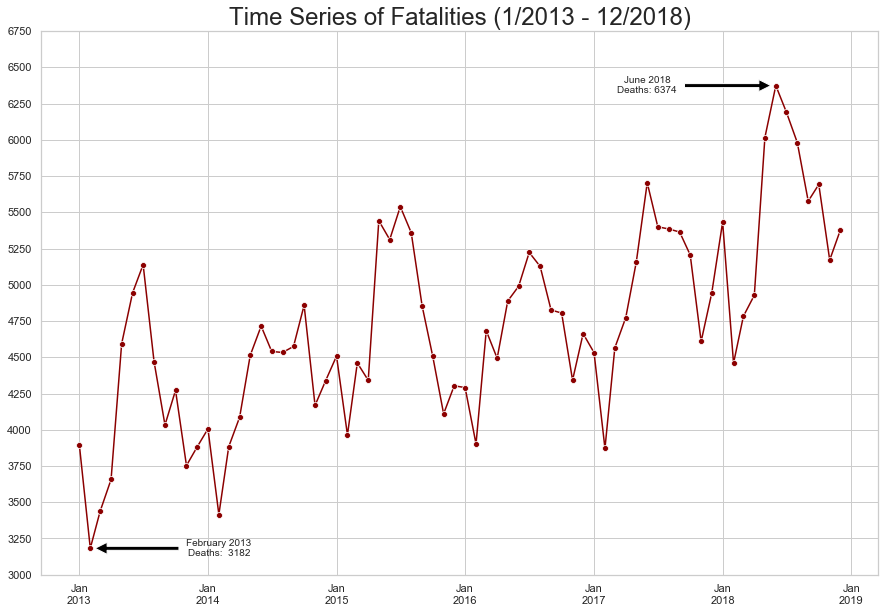

In [15]:
# Format xticks and axes
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%b\n%Y')

# Visualize complete time series of fatalities
fig2A, ax2A = plt.subplots(figsize=(15,10))
ax2A = sb.lineplot(x=fate_yrs.index.astype('datetime64'),
                   y='fatality',
                   data=fate_yrs,
                   color='#8b0000',marker='o')
ax2A.set_title('Time Series of Fatalities (1/2013 - 12/2018)',size=24)
ax2A.set_xlabel('',size=16)
ax2A.set_ylabel('',size=16)
ax2A.set_yticks([3000 + 250*i for i in range(16)])

ax2A.xaxis.set_major_locator(years)
ax2A.xaxis.set_major_formatter(years_fmt)

# Label months with minimum and maximum counts for fatalities
lbl_metric_val(fate_yrs.fatality,ax2A,np.max,lbl_txt='June 2018\nDeaths:',x_off=-12,y_off=0)
lbl_metric_val(fate_yrs.fatality,ax2A,np.min,lbl_txt='February 2013\nDeaths: ',x_off=12,y_off=0)

#plt.savefig('../graphics/CP1-02_fig02A.png') # Export plot to PNG file
plt.show()

<p>The time series above illustrates an upward trend in the monthly number of fatalities that result from EMS incidents across the six-year observation period (2013 through 2018). In addition, the frequency of fatalities tend to spike during the middle of each year. This observation warrants a closer inspection to determine whether or not the incident month is a deterministic factor of a fatality. <a href=#TOC>TOC</a></p> 

<a id='Sec02B'></a>
<h4>2B: Fatality Time Series - Per Year (1/2013 - 12/2018)</h4>

<p>Are there noticeable trends in fatalities per year?</p>

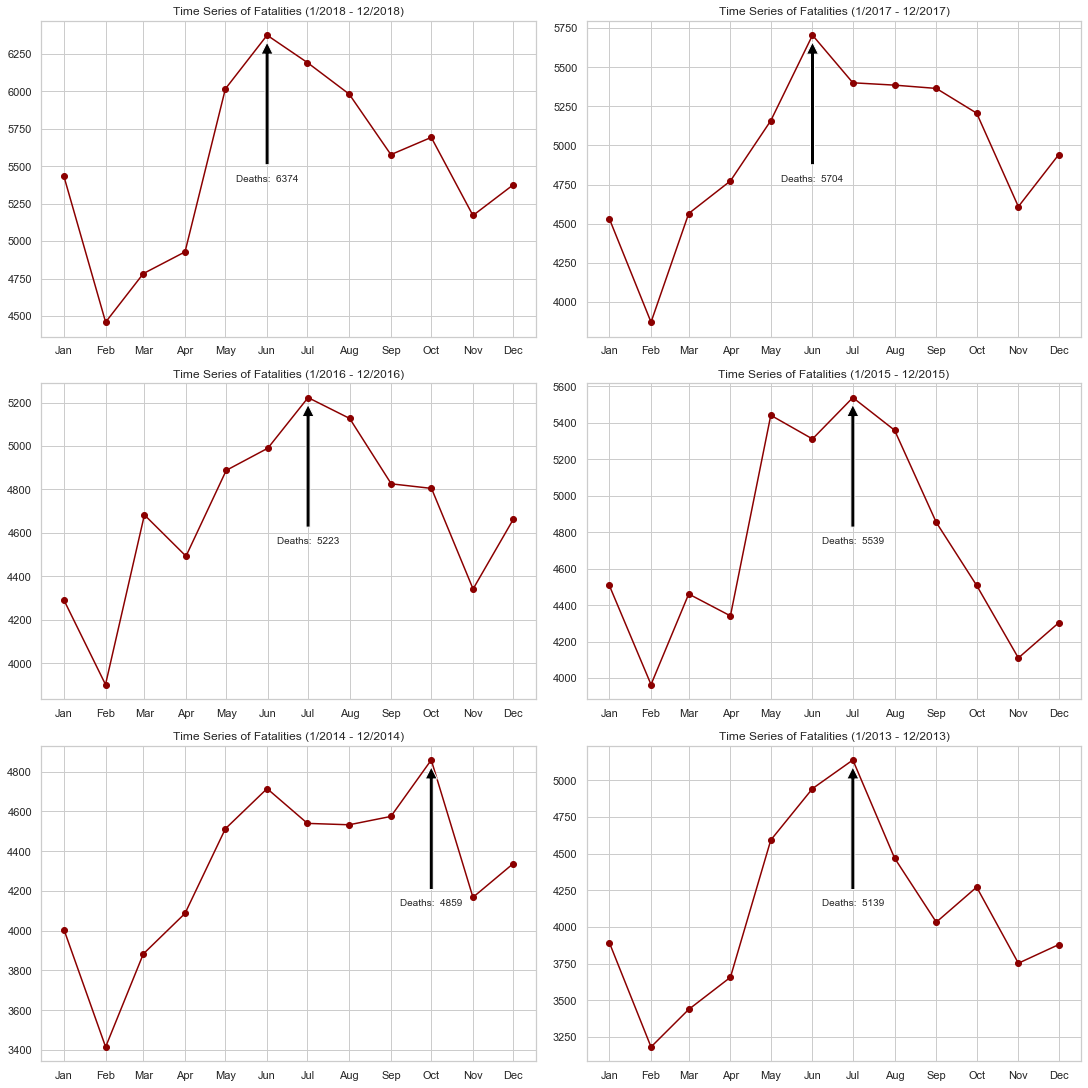

In [16]:
# Create list of years spanned by dataset
years = list(fatalities.index.year.unique())

# Create tuples for start and end month of each year
fate_period = [(str(year)+'-01',str(year)+'-12') for year in years]

# Subset counts of monthly fatalities by year
fate_arr = [fate_yrs.loc[str(s):str(e),:] for s,e in fate_period]
    
# Initialize plot and axes
nrows = int(math.ceil(len(fate_arr)/2)) # half the length of 'fate_arr'
ncols = 2
fig2B, ax2B = plt.subplots(nrows,ncols,figsize=(15,15),constrained_layout=True)

# Visualize time series of fatalities for each year
for k, ax in enumerate(ax2B.flat):
    yr = fate_arr[k].index[0].year
    ax.plot(np.array(fate_arr[k].index.astype('datetime64')),
            np.array(fate_arr[k].fatality),
            color='#8b0000',
            marker='o')
    ax.set_title(f'Time Series of Fatalities (1/{yr} - 12/{yr})')
    ax.set_ylabel('',size=14)
    
    # Format xticks
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_fmt)
    
    # Label maximum value
    y_off = (float(fate_arr[k].fatality.max()-fate_arr[k].fatality.min())/2)
    lbl_metric_val(fate_arr[k].fatality,ax,np.max,lbl_txt='Deaths: ',x_off=0,y_off=-y_off)
    
#plt.savefig('../graphics/CP1-02_fig02B.png') # Export plot to PNG file
plt.show()

<p>With the exception of the year 2014, fatalities resulting from EMS incidents tend to peak during the summertime in either June or July. <a href=#TOC>TOC</a></p>

<a id='Sec02C'></a>
<h4>2C: Fatalities by Month</h4>

<p>In which <em>month</em> does the highest frequency of fatalities occur?</p>

In [17]:
# Subset all fatalities by month
fate_mnth = fatalities[['fatality']].groupby(fatalities.index.month).sum()
fate_mnth.index = [calendar.month_abbr[i] for i in list(fate_mnth.index)] # format index
#fate_mnth

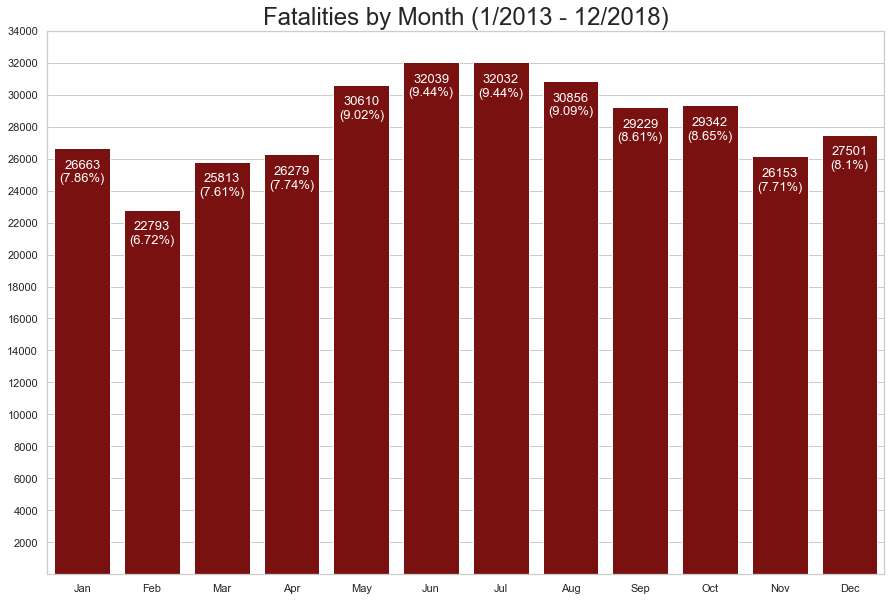

In [18]:
# Visualize barplot for monthly fatalities
fig2C, ax2C = plt.subplots(figsize=(15,10))
ax2C = sb.barplot(x=fate_mnth.index,y='fatality',
                  data=fate_mnth,
                  color='#8b0000')
ax2C.set_title('Fatalities by Month (1/2013 - 12/2018)',size=24)
ax2C.set_xticklabels(fate_mnth.index)
ax2C.set_ylabel('',size=16)
ax2C.set_yticks([2000*i for i in range(1,18)])

# Create data labels
total = sum([i.get_height() for i in ax2C.patches])    
for i in ax2C.patches:
    ax2C.text(i.get_x()+0.4,
              i.get_height()-1500,
              str(int(i.get_height()))+'\n('+str(round(i.get_height()/total*100,2))+'%)',
              fontsize=13,color='white',ha='center',va='center')

#plt.savefig('../graphics/CP1-02_fig02C.png') # Export plot to PNG file
plt.show()

<p>The plot above shows that the highest monthly frequency of fatalites during the six-year observation period (2013 through 2018) generally occur in the months of June and July. However, this observation in and of itself does not necessarily suggest that the month in which an EMS incident takes place may have strong a impact on whether or not a fatality will occur given that the frequencies are similiarly high in May and August. <a href=#TOC>TOC</a></p>

<a id='Sec02D'></a>
<h4>2D: Fatalities by Day of Year (2013 - 2018)</h4>

<p>On what <em>day of the year</em> does the highest frequency of fatalities occur?</p>

In [19]:
# Create pivot table for fatalities by time of year
temp_df = fatalities[['month','day','fatality']].groupby(['month','day']).sum().reset_index()
fate_tmOfYr = temp_df.pivot(index='month',columns='day',values='fatality')
fate_tmOfYr.index = list(calendar.month_abbr)[1:] # Rename index labels w/ abbreviated months

fate_tmOfYr

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
Jan,1372.0,816.0,834.0,883.0,933.0,865.0,878.0,896.0,919.0,901.0,...,792.0,861.0,786.0,872.0,768.0,737.0,845.0,878.0,813.0,803.0
Feb,814.0,837.0,890.0,896.0,834.0,916.0,777.0,816.0,737.0,838.0,...,766.0,775.0,816.0,798.0,814.0,783.0,807.0,156.0,NaN,NaN
Mar,846.0,817.0,876.0,827.0,836.0,831.0,830.0,785.0,929.0,864.0,...,779.0,836.0,756.0,836.0,875.0,868.0,841.0,773.0,861.0,838.0
Apr,878.0,847.0,834.0,864.0,833.0,825.0,891.0,873.0,906.0,886.0,...,878.0,841.0,795.0,852.0,854.0,909.0,909.0,929.0,787.0,NaN
May,909.0,1023.0,1098.0,1010.0,960.0,926.0,984.0,934.0,907.0,978.0,...,927.0,998.0,889.0,956.0,950.0,984.0,878.0,1024.0,1076.0,1113.0
Jun,1154.0,1096.0,1022.0,1054.0,919.0,942.0,970.0,1028.0,1095.0,1106.0,...,1060.0,1051.0,1136.0,1094.0,1042.0,996.0,1052.0,1087.0,1192.0,NaN
Jul,1140.0,1097.0,1111.0,978.0,1172.0,1092.0,1059.0,1008.0,962.0,1053.0,...,1095.0,1060.0,967.0,896.0,1004.0,988.0,1001.0,936.0,979.0,958.0
Aug,1025.0,987.0,1144.0,1015.0,1023.0,978.0,983.0,1005.0,986.0,1006.0,...,907.0,963.0,989.0,942.0,1022.0,992.0,917.0,999.0,988.0,1043.0
Sep,1059.0,952.0,1011.0,1059.0,923.0,998.0,950.0,1025.0,990.0,890.0,...,974.0,1012.0,1012.0,899.0,974.0,1003.0,926.0,973.0,913.0,NaN
Oct,990.0,974.0,1064.0,993.0,973.0,1055.0,989.0,904.0,943.0,1020.0,...,903.0,894.0,873.0,893.0,883.0,918.0,899.0,964.0,949.0,939.0


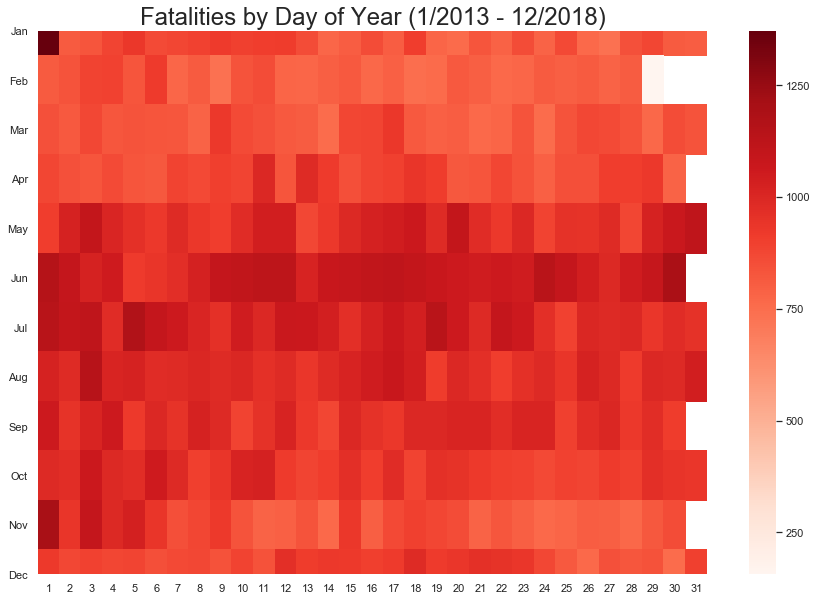

In [20]:
# Plot heatmap
fig2D, ax2D = plt.subplots(figsize=(15,10))
ax2D = sb.heatmap(fate_tmOfYr,cmap='Reds')
ax2D.set_title('Fatalities by Day of Year (1/2013 - 12/2018)',size=24)
ax2D.set_xlabel('')
ax2D.set_yticklabels(ax2D.get_yticklabels(), rotation=0)

#plt.savefig('../graphics/CP1-02_fig02D.png') # Export plot to PNG file
plt.show()

<p>This heatmap reinforces the observations from both the time series plots of fatalities per year and the preceding bar plot: the greatest annual fatalities tend to occur during the summer months (June, July, and August). It is worth noting, however, that the greatest number of fatalities on any single day (1,372) in the City of New York occurs on New Year's Day. <a href=#TOC>TOC</a></p>

<a id='Sec02E'></a>
<h4>2E: Fatalities by Time of Week (2013 - 2018)</h4>

<p>At what <em>time of the week</em> does the highest frequency of fatalities occur?</p>

In [21]:
# Create list of labels for weekday
wkdy_lbl = list(calendar.day_abbr)
wkdy_lbl.insert(0,wkdy_lbl.pop())

# Create list of labels for time of day
hr = {x.strftime('%H'):x.strftime('%I %p') for x in fatalities.index}
hr_od = OrderedDict(sorted(hr.items(),key=lambda t: t[0]))
hr_lbl = list(hr_od.values())

In [22]:
# Create pivot table for fatalities by time of week
temp_df = fatalities[['weekday','hour','fatality']].groupby(['weekday','hour']).sum().reset_index()
fate_tmOfWk = temp_df.pivot(index='weekday',columns='hour',values='fatality')
fate_tmOfWk.index = wkdy_lbl # Rename index labels
fate_tmOfWk.columns = hr_lbl # Rename column labels

fate_tmOfWk

,12 AM,01 AM,02 AM,03 AM,04 AM,05 AM,06 AM,07 AM,08 AM,09 AM,...,02 PM,03 PM,04 PM,05 PM,06 PM,07 PM,08 PM,09 PM,10 PM,11 PM
Sun,2346.0,2236.0,2050.0,1849.0,1746.0,1293.0,1155.0,1188.0,1357.0,1549.0,...,2195.0,2270.0,2250.0,2240.0,2214.0,2220.0,2182.0,2087.0,1922.0,1780.0
Mon,1482.0,1038.0,787.0,741.0,784.0,820.0,1039.0,1466.0,2125.0,2350.0,...,3216.0,3352.0,3039.0,2949.0,2677.0,2450.0,2276.0,2071.0,1910.0,1519.0
Tue,1281.0,962.0,783.0,676.0,601.0,771.0,997.0,1442.0,2004.0,2218.0,...,3031.0,3110.0,2954.0,2872.0,2680.0,2404.0,2194.0,2073.0,1909.0,1596.0
Wed,1352.0,981.0,836.0,727.0,690.0,794.0,986.0,1388.0,1878.0,2189.0,...,3153.0,3240.0,2949.0,2868.0,2752.0,2495.0,2281.0,2166.0,1906.0,1712.0
Thu,1408.0,1053.0,882.0,715.0,730.0,726.0,967.0,1446.0,1947.0,2151.0,...,3155.0,3156.0,3112.0,2858.0,2738.0,2496.0,2376.0,2189.0,2096.0,1860.0
Fri,1566.0,1223.0,1069.0,847.0,855.0,906.0,1028.0,1457.0,1896.0,2144.0,...,3276.0,3447.0,3211.0,3021.0,2966.0,2793.0,2611.0,2485.0,2484.0,2483.0
Sat,2208.0,1971.0,1851.0,1743.0,1567.0,1227.0,1139.0,1269.0,1437.0,1713.0,...,2496.0,2673.0,2425.0,2400.0,2523.0,2487.0,2504.0,2463.0,2463.0,2546.0


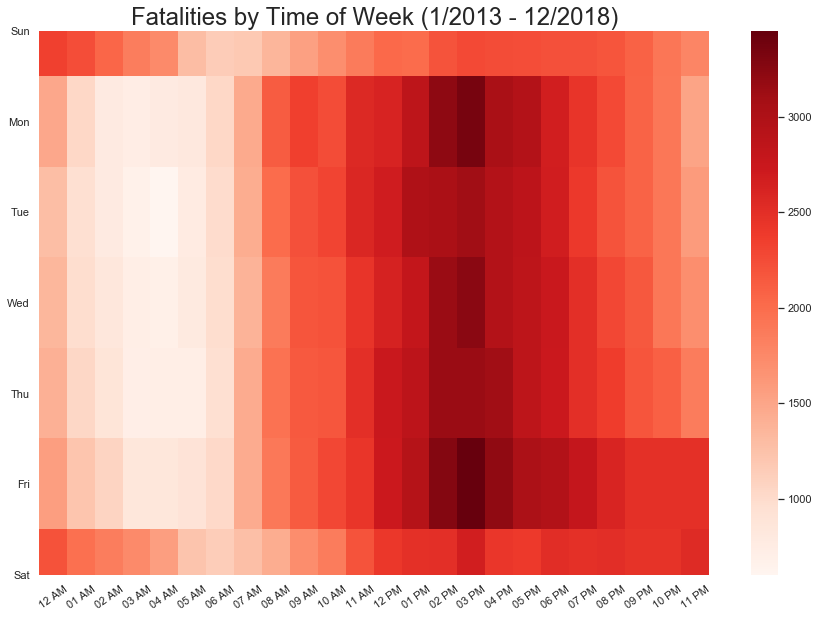

In [23]:
# Plot heatmap
fig2E, ax2E = plt.subplots(figsize=(15,10))
ax2E = sb.heatmap(fate_tmOfWk,cmap='Reds')
ax2E.set_title('Fatalities by Time of Week (1/2013 - 12/2018)',size=24)
ax2E.set_xticklabels(ax2E.get_xticklabels(), rotation=35)
ax2E.set_yticklabels(ax2E.get_yticklabels(), rotation=0)

#plt.savefig('../graphics/CP1-02_fig02E.png') # Export plot to PNG file
plt.show()

<p>The heatmap shows that the greatest number of fatalities during any given week tend to occur between 3:00 pm and 4:00 pm (21,248), with noticeable peaks on Mondays (3,352) and Fridays (3,447). <a href=#TOC>TOC</a></p>

<hr>

<h2 style="text-transform: uppercase;">3. Incident Response Times</h2>

<a id='Sec03A'></a>
<h4>3A: Total Response Times</h4>

<p>Are there any noticeable trends in the distribution of incident response times?<p>

In [24]:
rspn_tm = df[['response_time','fatality']]
#rspn_tm.head()

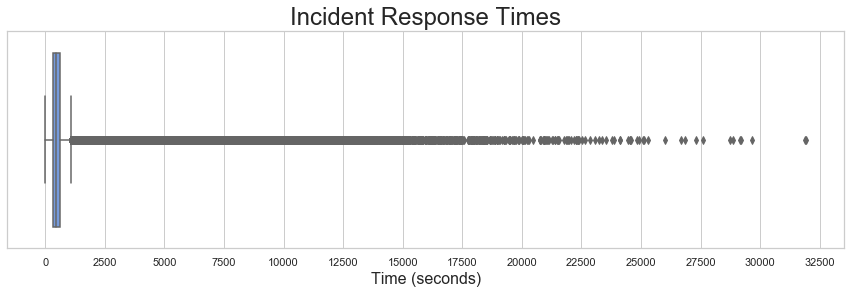

In [25]:
# Visualize spread of response times
fig3A1, ax3A1 = plt.subplots(figsize=(15,4))
ax3A1 = sb.boxplot(x='response_time',
                   data=rspn_tm,
                   orient='h',color='#6495ED')
ax3A1.set_title('Incident Response Times',size=24)
ax3A1.set_xlabel('Time (seconds)',size=16)
ax3A1.set_xticks([2500*i for i in range(14)])
ax3A1.set_ylabel('',size=16)

#plt.savefig('../graphics/CP1-02_fig03A1.png') # Export plot to PNG file
plt.show()

<p>The plot above illustrates a large volume of outliers in the dataset that obscure any meaningful patterns. For this reason, it is worth evaluating standard summary statistics for the distribution to gain deeper insights.</p>

In [26]:
# Calculate summary statistics
rspn_tm_mu = np.mean(rspn_tm.response_time)
quartiles = np.percentile(rspn_tm.response_time,[25,50,75])
rspn_tm_min, rspn_tm_max = rspn_tm.response_time.min(),rspn_tm.response_time.max()

# Identify outliers
rspn_tm_maxf = quartiles[2]+1.5*(quartiles[2]-quartiles[0]) # "Maximum" (Q3 + 1.5*IQR)
outliers = rspn_tm.response_time[rspn_tm.response_time>rspn_tm_maxf]

# Output statistics
print(f'Total Number of Observations: {len(rspn_tm.response_time):8}')
print(f'Number of Outliers:           {len(outliers):8}')
print()
print(f'Mean:        {rspn_tm_mu:8.2f}')
print(f'Q1:          {quartiles[0]:8.2f}')
print(f'Median (Q2): {quartiles[1]:8.2f}')
print(f'Q3:          {quartiles[2]:8.2f}')
print()
print(f'Actual Minimum Response Time:          {rspn_tm_min:9.2f}')
print(f'\"Maximum\" Response Time (Q3 + 1.5*IQR):{rspn_tm_maxf:9.2f}')
print(f'Actual Maximum Response Time:          {rspn_tm_max:9.2f}')

Total Number of Observations:  8054500
Number of Outliers:             577993

Mean:          556.46
Q1:            309.00
Median (Q2):   436.00
Q3:            624.00

Actual Minimum Response Time:               0.00
"Maximum" Response Time (Q3 + 1.5*IQR):  1096.50
Actual Maximum Response Time:           31931.00


The summary statistics confirm that there are a large number of outlier observations, from the perspective of `response_time`. The outliers can be excluded from this examination; however, these values <em>should not</em>  be omitted from future statistical analyses.

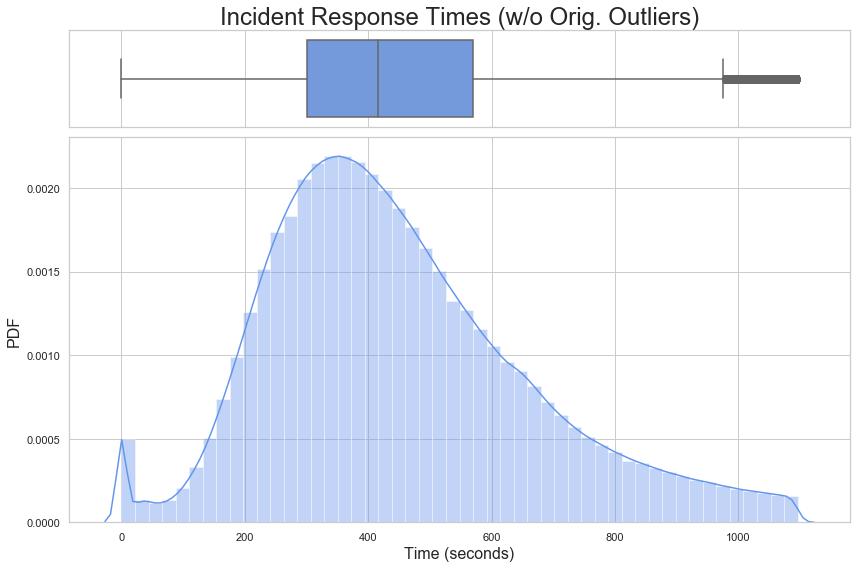

In [27]:
# Remove outlier observations from data
rspn_tm_adj = rspn_tm[rspn_tm.response_time<=rspn_tm_maxf]

# Visualize spread of response times without original outlier observations
fig3A2, ax3A2 = plt.subplots(2,figsize=(12,8),sharex=True,
                             gridspec_kw={"height_ratios": (.20,.80)})
sb.boxplot(rspn_tm_adj.response_time,
           ax=ax3A2[0],color='#6495ED')
sb.distplot(rspn_tm_adj.response_time,
            ax=ax3A2[1],color='#6495ED')
ax3A2[0].set_title('Incident Response Times (w/o Orig. Outliers)',size=24)
ax3A2[0].set_xlabel('')
ax3A2[1].set_xlabel('Time (seconds)',size=16)
ax3A2[1].set_ylabel('PDF',size=16)

plt.tight_layout()
#plt.savefig('../graphics/CP1-02_fig03A2.png') # Export plot to PNG file
plt.show()

<p>The overall distribution of incident response times--with the removal of original outliers--appears to be positively-skewed. This observation will be examined in greater detail through future statistical analyses. <a href=#TOC>TOC</a></p>

<a id='Sec03B'></a>
<h4>3B: Response Times by Incident Outcome</h4>

<p>How do the distributions of response times vary based on the <em>incident outcome</em>?</p>

+ <strong>Fatalities</strong> (`fatality == True`) 
+ <strong>Survivals</strong> (`fatality == False`)

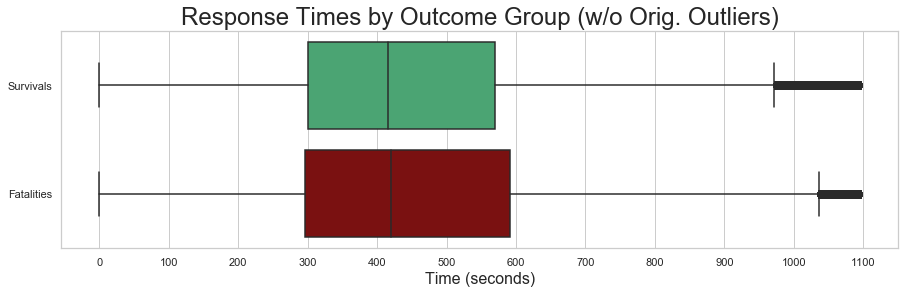

In [28]:
my_pal = {True:'#8b0000',False:'#3CB371'} # custom color palette for outcome group

# Visualize spread of response times by outcome group
fig3B1, ax3B1 = plt.subplots(figsize=(15,4))
ax3B1 = sb.boxplot(x='response_time',y='fatality',
                   data=rspn_tm_adj,
                   orient='h',palette=my_pal)
ax3B1.set_title('Response Times by Outcome Group (w/o Orig. Outliers)',size=24)
ax3B1.set_xlabel('Time (seconds)',size=16)
ax3B1.set_xticks([100*i for i in range(12)])
ax3B1.set_ylabel('',size=16)
ax3B1.set_yticklabels(['Survivals','Fatalities'])

#plt.savefig('../graphics/CP1-02_fig03B1.png') # Export plot to PNG file
plt.show()

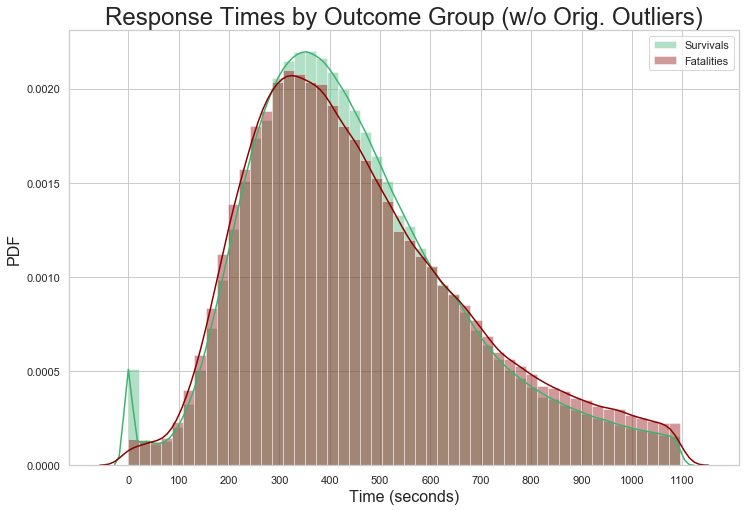

In [29]:
# Visualize distribution of response times for outcome groups on same axis
fig3B2, ax3B2 = plt.subplots(figsize=(12,8))
ax3B2 = sb.distplot(rspn_tm_adj[rspn_tm_adj.fatality==False].response_time,
                    color='#3CB371',label='Survivals')
ax3B2 = sb.distplot(rspn_tm_adj[rspn_tm_adj.fatality==True].response_time,
                    color='#8b0000',label='Fatalities')
ax3B2.set_title('Response Times by Outcome Group (w/o Orig. Outliers)',size=24)
ax3B2.set_xlabel('Time (seconds)',size=16)
ax3B2.set_xticks([100*i for i in range(12)])
ax3B2.set_ylabel('PDF',size=16)

plt.legend()
#plt.savefig('../graphics/CP1-02_fig03B2.png') # Export plot to PNG file
plt.show()

The boxplot suggests that distributions of `response_time` for fatalities and survivals are very similar. This is supported by the histogram above which illustrates both distributions on the same axes. However, further statistical analysis will need to be performed to determine whether or not there is a significant difference between the response times for the two samples. <p><a href=#TOC>TOC</a></p>

<a id='Sec03C'></a>
<h4>3C: Response Time by Final Severity Level</h4>

<p>Does the response time of an incident vary based on the <em>severity level code</em> ascribed to it?</p>

In [30]:
rspn_tm_sev = df[['final_severity_level','life_threatening','response_time','fatality']]
rspn_tm_sev_adj = rspn_tm_sev[rspn_tm_sev.response_time<=rspn_tm_maxf]
#rspn_tm_sev_adj.head()

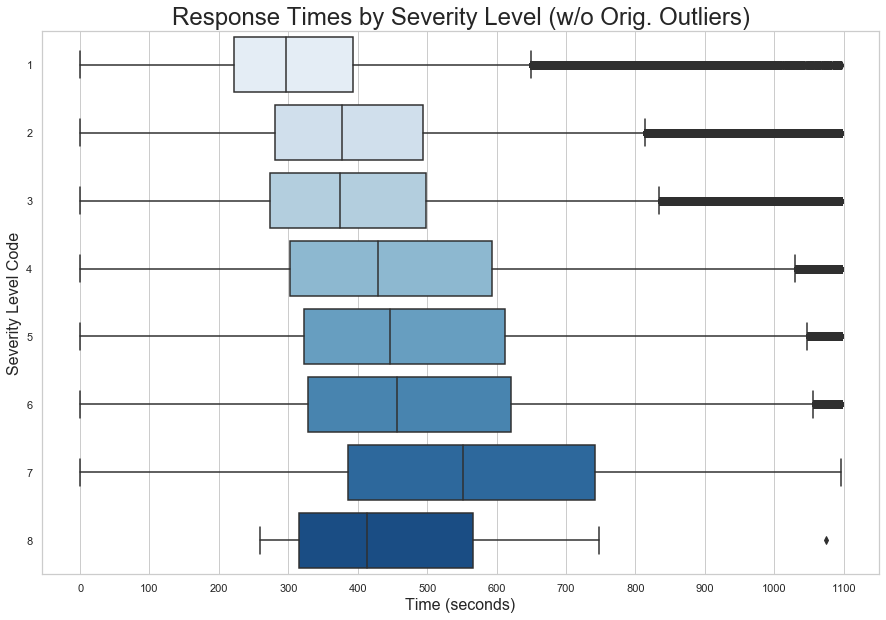

In [31]:
# Visualize spread of response times for each severity level code
fig3C1, ax3C1 = plt.subplots(figsize=(15,10))
ax3C1 = sb.boxplot(x='response_time',y='final_severity_level',
                   data=rspn_tm_sev_adj,
                   orient='h',palette='Blues')
ax3C1.set_title('Response Times by Severity Level (w/o Orig. Outliers)',size=24)
ax3C1.set_xlabel('Time (seconds)',size=16)
ax3C1.set_xticks([100*i for i in range(12)])
ax3C1.set_ylabel('Severity Level Code',size=16)

#plt.savefig('../graphics/CP1-02_fig03C1.png') # Export plot to PNG file
plt.show()

<p>The spread of response times varies greatly across the different severity level codes. For this reason, the response times should be examined when severity level codes are grouped by their <em>incident threat classification</em>.</p>

+ <strong>Lethal</strong> (`life_threatening == True`):  Severity Level Codes 1, 2, 3
+ <strong>Non-Lethal</strong> (`life_threatening == False`): Severity Level Codes 4, 5, 6, 7, 8

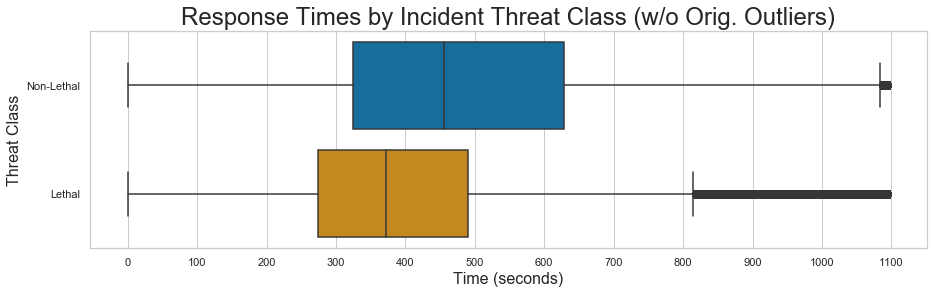

In [32]:
# Visualize spread of response times for each threat class
fig3C2, ax3C2 = plt.subplots(figsize=(15,4))
ax3C2 = sb.boxplot(x='response_time',y='life_threatening',
                   data=rspn_tm_sev_adj,
                   orient='h',palette='colorblind')
ax3C2.set_title('Response Times by Incident Threat Class (w/o Orig. Outliers)',size=24)
ax3C2.set_xlabel('Time (seconds)',size=16)
ax3C2.set_xticks([100*i for i in range(12)])
ax3C2.set_ylabel('Threat Class',size=16)

# Customize ytick labels
ytck = ax3C2.get_yticks().tolist()
ytck[0] = 'Non-Lethal'
ytck[1] = 'Lethal'
ax3C2.set_yticklabels(ytck)

#plt.savefig('../graphics/CP1-02_fig03C2.png') # Export plot to PNG file
plt.show()

<p>The distribution of response times can also be segmented within each threat class by the incident outcome groups <strong>fatalities</strong> and <strong>survivals</strong>.</p>

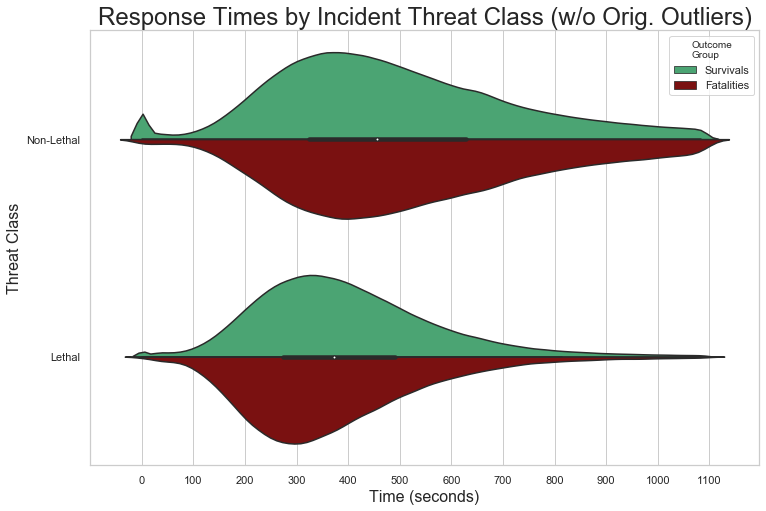

In [33]:
my_pal = {True:'#8b0000',False:'#3CB371'} # custom color palette for outcome group

# Visualize distribution by threat class and outcome group
fig3C3, ax3C3 = plt.subplots(figsize=(12,8))
ax3C3 = sb.violinplot(x='response_time',y='life_threatening',
                      data=rspn_tm_sev_adj,
                      hue='fatality',orient='h',palette=my_pal,split=True)
ax3C3.set_title('Response Times by Incident Threat Class (w/o Orig. Outliers)',size=24)
ax3C3.set_xlabel('Time (seconds)',size=16)
ax3C3.set_xticks([100*i for i in range(12)])
ax3C3.set_ylabel('Threat Class',size=16)

# Customize ytick labels
ytck = ax3C3.get_yticks().tolist()
ytck[0] = 'Non-Lethal'
ytck[1] = 'Lethal'
ax3C3.set_yticklabels(ytck)

# Customize legend
handles, labels = ax3C3.get_legend_handles_labels()
labels = ['Survivals','Fatalities']
ax3C3.legend(title='Outcome\nGroup',handles=handles,labels=labels)

#plt.savefig('../graphics/CP1-02_fig03C3.png') # Export plot to PNG file
plt.show()

<p>The distribution of response times between the outcome groups within the <strong>Non-Lethal</strong> threat class are very similar to each other. However, there is a noticeable difference between the distributions within the <strong>Lethal</strong> threat class. This can be explored in greater depth through future statistical analyses. <a href=#TOC>TOC</a></p>

<hr>

<h2 style="text-transform: uppercase;">4. Incident Call Types &amp; Severity Levels</h2>

<a id='Sec04A'></a>
<h4>4A: Fatalities by Call Type</h4>

<p>Which category of <em>call types</em> for EMS incidents result in the greatest number of fatalities?</p>

In [34]:
fate_type = fatalities[['fatality']].groupby(fatalities.final_call_type).sum().sort_values(by='fatality',ascending=True)
#fate_type

In [35]:
fatalities[fatalities.fatality==True].final_call_type.value_counts(normalize=True)

EDP       0.160924
ARREST    0.155377
DRUG      0.130612
INJURY    0.122481
UNC       0.093001
            ...   
MCI30P    0.000003
MCI59     0.000003
MCI22P    0.000003
MCI80     0.000003
MCI35P    0.000003
Name: final_call_type, Length: 82, dtype: float64

<p>There are 82 unique EMS incident call types that result in fatalities. Therefore, the scope should be limited to the ten call types with the greatest frequency of fatalities.</p>

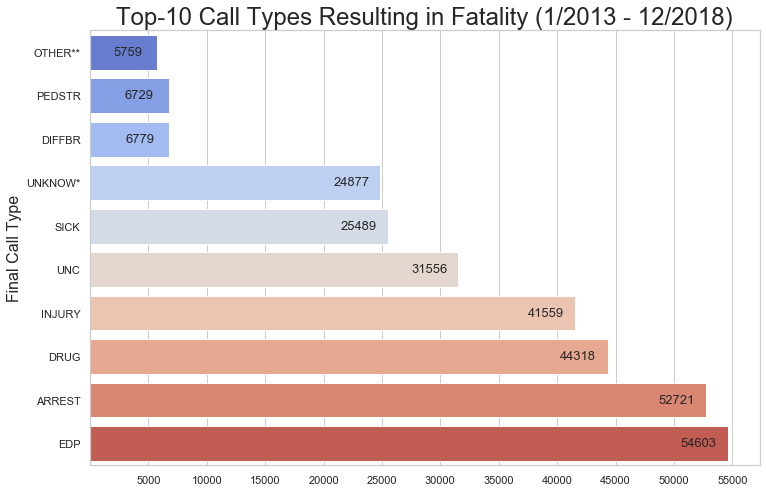

In [36]:
# Visualize frequency of fatalities by call type
fig4A, ax4A = plt.subplots(figsize=(12,8))
ax4A = sb.barplot(x='fatality',y=fate_type.tail(10).index,
                  data=fate_type.tail(10).sort_values(by='fatality',ascending=True),
                  palette='coolwarm')
ax4A.set_title('Top-10 Call Types Resulting in Fatality (1/2013 - 12/2018)',size=24)
ax4A.set_xlabel('',size=16)
ax4A.set_xticks([5000*i for i in range(1,12)])
ax4A.set_ylabel('Final Call Type',size=16)

# Create data labels
for i in ax4A.patches:
    ax4A.text(i.get_width()-2500,
              i.get_y()+0.4,
              str(int(i.get_width())),
              fontsize=13,ha='center',va='center')

# Customize ytick labels
ytck = fate_type.tail(10).index.tolist()
ytck[0] = 'OTHER**'
ytck[3] = 'UNKNOW*'
ax4A.set_yticklabels(ytck)
    
#plt.savefig('../graphics/CP1-02_fig04A.png') # Export plot to PNG file
plt.show()

<p>The are five call types that account for 66.24% of all fatalities:</p>
<ul>
    <li>EDP = Psychiatric Patient (16.09%)</li>
    <li>ARREST = Cardiac Arrest (15.54%%)</li>
    <li>DRUG = HX Drug or Alcohol Abuse (13.06%)</li>
    <li>INJURY = Non-Critical Injury (12.25%)</li>
    <li>UNC = Unconscious Patient (9.30%)</li>
</ul>
<p>Further analysis willbe performed to determine whether or not this has a significant impact on an incident outcome. <a href=#TOC>TOC</a></p>

<a id='Sec04B'></a>
<h4>4B: Incident Outcomes by Severity Levels</h4>

<p>Which <em>severity level</em> results in the greatest number of fatalitites? Survivals?</p>

In [37]:
# Subset all fatalities by initial and final severity level code
sev_lvl = df[['final_severity_level','life_threatening','fatality']]
#sev_lvl

,final_severity_level,life_threatening,fatality
incident_datetime,,,
2018-12-31 23:59:46,2,True,False
2018-12-31 23:49:42,2,True,False
2018-12-31 23:24:58,6,False,False
2018-12-31 23:04:54,6,False,False
2018-12-31 22:08:50,3,True,False
...,...,...,...
2013-01-03 08:43:49,5,False,False
2013-01-02 22:24:38,2,True,False
2013-01-01 21:25:48,6,False,False


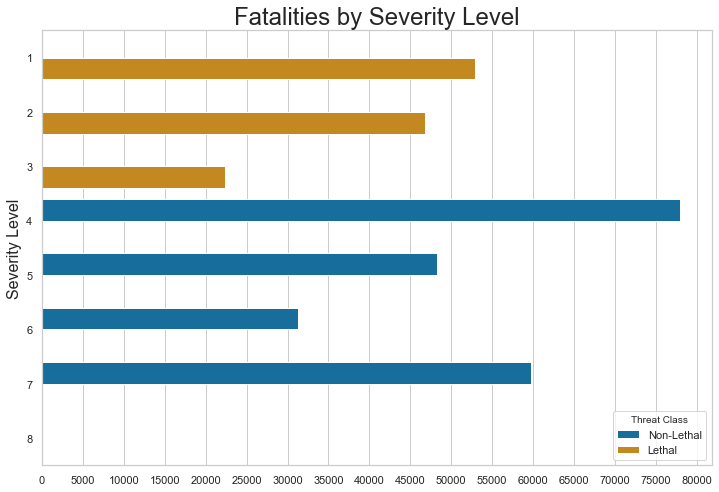

In [38]:
# Visualize fatalities by severity level
fig4B1, ax4B1 = plt.subplots(figsize=(12,8))
ax4B1 = sb.countplot(y='final_severity_level',
                     data=sev_lvl[sev_lvl.fatality==True],
                     hue='life_threatening',palette='colorblind')
ax4B1.set_title('Fatalities by Severity Level',size=24)
ax4B1.set_xlabel('',size=16)
ax4B1.set_xticks([5000*i for i in range(17)])
ax4B1.set_ylabel('Severity Level',size=16)

# Customize legend
handles, labels = ax4B1.get_legend_handles_labels()
labels = ['Non-Lethal','Lethal']
ax4B1.legend(title='Threat Class',handles=handles,labels=labels,loc='lower right')

#plt.savefig('../graphics/CP1-02_fig04B1.png') # Export plot to PNG file
plt.show()

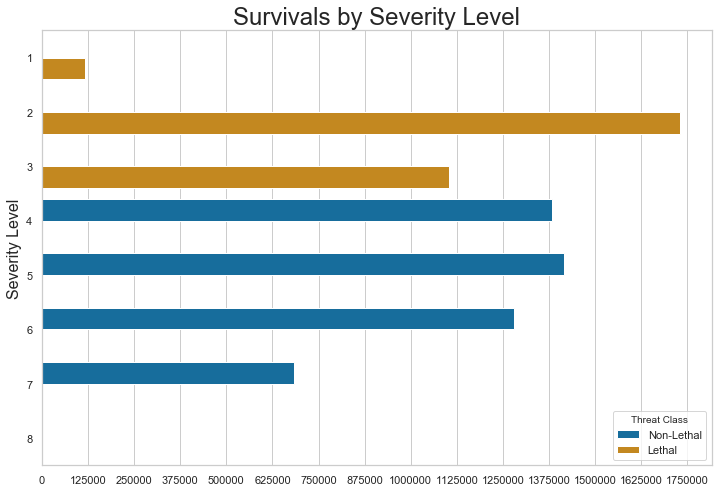

In [39]:
# Visualize survivals by severity level
fig4B2, ax4B2 = plt.subplots(figsize=(12,8))
ax4B2 = sb.countplot(y='final_severity_level',
                     data=sev_lvl[sev_lvl.fatality==False],
                     hue='life_threatening',palette='colorblind')
ax4B2.set_title('Survivals by Severity Level',size=24)
ax4B2.set_xlabel('',size=16)
ax4B2.set_xticks([125000*i for i in range(15)])
ax4B2.set_ylabel('Severity Level',size=16)

# Customize legend
handles, labels = ax4B2.get_legend_handles_labels()
labels = ['Non-Lethal','Lethal']
ax4B2.legend(title='Threat Class',handles=handles,labels=labels,loc='lower right')

#plt.savefig('../graphics/CP1-02_fig04B2.png') # Export plot to PNG file
plt.show()

<p><a href=#TOC>TOC</a></p>

<hr>

<h2 style="text-transform: uppercase;">5. Fatalities by Georgraphic Region</h2>

<a id='Sec05A'></a>
<h4>5A: Fatalities by Borough</h4>

<p>What is the frequency of fatalities within each borough of the City of New York?</p>

In [40]:
# Subset all fatalities by borough
fate_brgh = fatalities[['fatality']].groupby(fatalities.borough).sum().sort_values(by='fatality',ascending=True)
fate_brgh.index = fate_brgh.index.astype(object)
fate_brgh.drop(index='UNKNOWN',inplace=True)
#fate_brgh

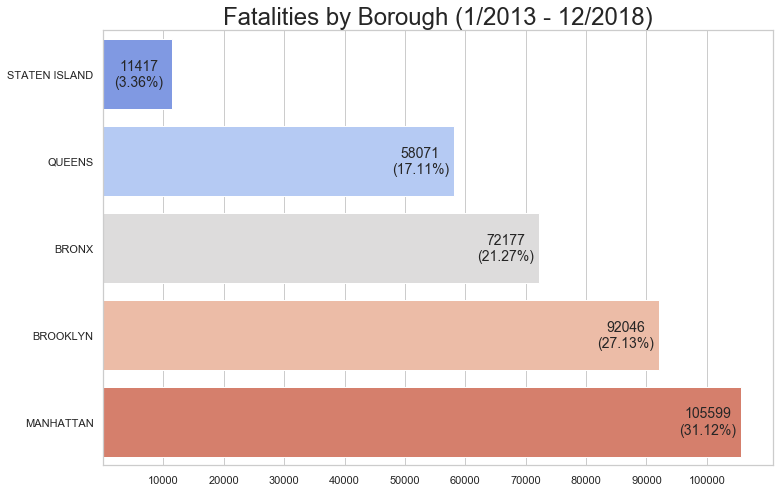

In [41]:
# Create plot, title, and axes labels
fig5A, ax5A = plt.subplots(figsize=(12,8))
ax5A = sb.barplot(y=fate_brgh.index,
                  x='fatality',
                  data=fate_brgh.sort_values(by='fatality',ascending=True),
                  palette='coolwarm')
ax5A.set_title('Fatalities by Borough (1/2013 - 12/2018)',size=24)
ax5A.set_xlabel('',size=16)
ax5A.set_xticks([10000*i for i in range(1,11)])
ax5A.set_ylabel('',size=16)

# Create data labels
total = sum([i.get_width() for i in ax5A.patches])
for i in ax5A.patches:
    ax5A.text(i.get_width()-5500,
             i.get_y()+0.4,
             str(int(i.get_width()))+'\n('+str(round(i.get_width()/total*100,2))+'%)',
             fontsize=14,ha='center',va='center')

#plt.savefig('../graphics/CP1-02_fig05A.png') # Export plot to PNG file
plt.show()

<p>The bar chart shows that the highest portion of fatalities that result from EMS incidents (31.12%) occur in Manhattan. This an interesting observation given that the populations of Brooklyn and Queens, respectively, are each historically greater than the population of Manhattan. <a href=#TOC>TOC</a></p>

<em>Source: <a href="https://www.census.gov/data/tables/time-series/demo/popest/2010s-national-total.html" target="_blank"> U.S. Census Bureau, Population Division, Annual Estimates of the Resident Population: April 1, 2010 to July 1, 2018</a></em>

<a id='Sec05B'></a>
<h4>5B: Fatalities by ZIP Code</h4>

<p>Which ZIP codes contain the highest concentration of fatalities over the six-year period?</p>

In [42]:
# Subset all fatalities by ZIP code
fate_zipcode = fatalities[['fatality']].groupby([fatalities.zipcode]).sum().sort_values(by='fatality',ascending=False)
#fate_zipcode

In [43]:
def calc_color(data, color_map, n_colors):
    
    # Create list of HEX colors for bins
    if color_map != None: 
        cmap = cm.get_cmap(color_map, n_colors)
    else:            
        color_map = 'OrRd'
        cmap = cm.get_cmap(color_map, n_colors)
    color_sq = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    
    # Create color bins for specified quantiles
    new_data, bins = pd.qcut(data, n_colors, retbins=True,labels=list(range(n_colors)))
    color_ton = []
    for val in new_data:
        color_ton.append(color_sq[val]) 
    colors = sb.color_palette(color_map, n_colors=n_colors)
    sb.palplot(colors, 0.6);

    # Print legend for color bins
    print('COLOUR BIN LEGEND')
    for i in range(n_colors):   
        print(f'{i+1:2}:  {int(bins[i]):4} - {int(bins[i+1])-1}')
    print()        
    for i in range(n_colors):
        print(f'   {i+1}', end='')
    return color_ton, bins;

In [44]:
def plot_map_fill_zipcodes(sf, title, zip_ids, color_ton, bins, 
                           x_lim = None, y_lim = None, figsize = (12,10)):
    '''
    Plot map with lim coordinates
    '''        
    fig, ax = plt.subplots(figsize = figsize)
    ax.set_title(title,size=24)
    
    # Disable plot tick labels
    plt.tick_params(labelbottom = False, labelleft = False)
    
    # Plot shape of ZIP code areas
    for shape in sf.shapeRecords():
            x = [i[0] for i in shape.shape.points[:]]
            y = [i[1] for i in shape.shape.points[:]]
            ax.plot(x, y, 'k')
            
    # Fill color intensity for ZIP code areas
    for id in zip_ids:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        try:
            ax.fill(x_lon,y_lat, color_ton[zip_ids.index(id)])
        except:
            ax.fill(x_lon,y_lat, facecolor='#fff5f0')
    
    # Create a boundary window to view the heatmap
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        
    #plt.savefig('../graphics/CP1-02_fig05B.png') # Export plot to PNG file
    plt.show()

In [45]:
def plot_zipcodes_data(sf, title, zipcodes, data, 
                       color_map, n_colors, 
                       x_lim = None, y_lim = None):
    '''
    Plot map with selected zipcodes, using 
    specified color map and number of bins
    '''  
    color_ton, bins = calc_color(data, color_map, n_colors)
    df = read_shapefile(sf)
    zip_ids = []
    for i in zipcodes:
        zip_ids.append(map_df[map_df.zipcode== i].index.to_numpy()[0])
    plot_map_fill_zipcodes(sf, title, zip_ids, 
                           color_ton, bins, 
                           x_lim, y_lim, figsize = (15,15))

COLOUR BIN LEGEND
 1:     0 - 23
 2:    24 - 289
 3:   290 - 577
 4:   578 - 810
 5:   811 - 1272
 6:  1273 - 1738
 7:  1739 - 2230
 8:  2231 - 2755
 9:  2756 - 4133
10:  4134 - 5776

   1   2   3   4   5   6   7   8   9   10

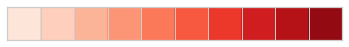

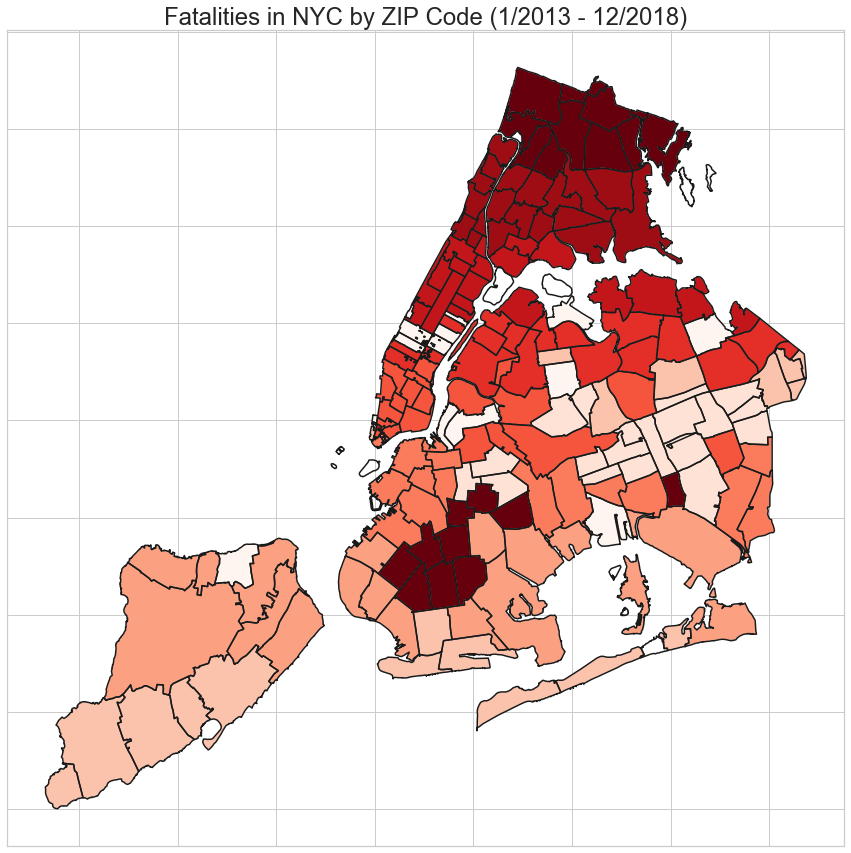

In [46]:
# Set function parameters
title = 'Fatalities in NYC by ZIP Code (1/2013 - 12/2018)'

city = [zipcode for zipcode in map_df.zipcode]
data = list(fate_zipcode.fatality) # frequency of fatalities per ZIP code
color_pallete = 'Reds'

# Plot geographic heatmap
plot_zipcodes_data(sf, title, city, data, color_pallete, 10)

<p>Although there are specific neighbourhoods in the boroughs of Brooklyn and The Bronx that have a high concentrations of fatalities, the plot above clearly illustrates that the borough with the greatest number of fatalities is actually Manhattan. <a href=#TOC>TOC</a></p>